In [1]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [2]:
char_list = ' شه045لذس2ط71قك83رجت6بثا9دضزوعظغىفنمخصح' # i get this set of chars by unique the data labels of every chars 
OUTPUTS_LENS = len(char_list)                         # you can use all arabic chars and numbers instead of That 
                                                      # note that arabic chars has diferrence forms that all may be 84 but in this case we only the single form 
                                                      # so the output layer will has the out len of this char set only

def encode_to_labels(txt):                           
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [4]:
OUTPUTS_LENS

39

In [60]:
DATA_DIR = './data'
img_dir = os.path.join(DATA_DIR,'train')

In [61]:
os.listdir(DATA_DIR)

['train_images',
 'train_labels.csv',
 'test_images',
 'sample_submission.csv',
 'train_bbxs']

In [62]:
df = pd.read_csv(os.path.join(DATA_DIR,'train_labels.csv'))

In [63]:
df.head()

,img_name,label
0,00000.jpg,ا ظ ش 0 2 9
1,00001.jpg,ل ل 1
2,00002.jpg,ث ص ش 5 5
3,00003.jpg,ث غ د 2 5 2
4,00004.jpg,ش ف ب 3 3 4


In [64]:
df.tail()

,img_name,label
5274,05274.jpg,ك ث 0 9
5275,05275.jpg,خ ح 4 9
5276,05276.jpg,ل ج 1 4
5277,05277.jpg,ض ت 8 7 4
5278,05278.jpg,ت ط م 9 3


In [5]:
def data_aug(img):
    #do some data ougmantation for training set to increase accuracy
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        #img = tf.keras.preprocessing.image.random_rotation(img,rg=np.random.randint(25),fill_mode='nearest') 
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

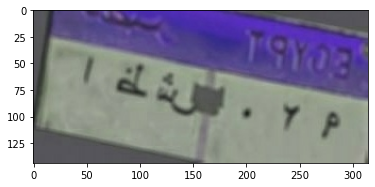

In [18]:
img = cv2.imread(os.path.join(img_dir,'00000.jpg'))
augmented_images = data_aug(img)

plt.imshow(augmented_images[2])    

In [6]:
def aug_df(df):
    #do aug and save version of photo in drive 
    for img_name in df['img_name']:
        name = img_name.split('.')[0]
        label = df[df['img_name']==img_name].iloc[0,1]
        img_path = os.path.join(img_dir,img_name)
        img = cv2.imread(img_path)
        if img is None: continue
        imgs = data_aug(img)
        i = 0
        for image in imgs:
            aug_name = f'aug_{i}_{name}.jpg'
            cv2.imwrite(os.path.join(img_dir, aug_name),image.numpy())
            df = df.append({'img_name':aug_name,'label':label},ignore_index=True)
            i+=1
            
    return df

        
        

In [20]:
df_final = aug_df(df)

[ WARN:0@561.062] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data3/train/05298.jpg'): can't open/read file: check file path/integrity


In [21]:
len(df_final)

53781

In [22]:
df_valid = df

In [7]:
from random import randint

def show_random_image(df):
    #show randow image for test 
    i = randint(0, len(df))
    file_name = df.iloc[i,0]
    file_path = os.path.join(img_dir,file_name)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB )
    plt.imshow(img)
    print(f"Image Shape: {img.shape}\nLabel: {df.iloc[i,1]}")
    return img

Image Shape: (163, 370, 3)
Label: خ ن م 9 2 0


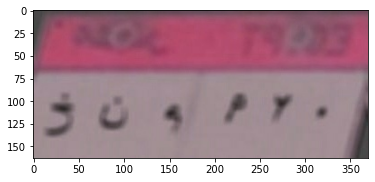

In [24]:
im = show_random_image(df_final)

In [25]:
df_valid = df_valid.sample(frac=1).reset_index(drop=True) #shaffle the data for training 

In [26]:
df_final = df_final.sample(frac=1).reset_index(drop=True) #shaffle the data for training 

In [56]:
df_final.to_csv(os.path.join(DATA_DIR,'aug_train.csv'))  #shaffle the data for training 

In [27]:
# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

max_label_len = 0
 
for file in df_final.loc[:,'img_name']:
    img = cv2.imread(os.path.join(img_dir, file))
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    txt = df_final[df_final['img_name']==file].iloc[0,1]
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    orig_txt.append(txt)   
    train_label_length.append(len(txt))
    train_input_length.append(31)
    training_img.append(img)
    training_txt.append(encode_to_labels(txt)) 

max_label_len

[ WARN:0@571.527] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data3/train/05298.jpg'): can't open/read file: check file path/integrity


‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍
‍


15

In [28]:
# lists for valid dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i =1 
for file in df_valid.loc[:,'img_name']:
    img = cv2.imread(os.path.join(img_dir, file))
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    txt = df_valid[df_valid['img_name']==file].iloc[0,1]
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    if i%10 == 0:     
        valid_orig_txt.append(txt)   
        valid_label_length.append(len(txt))
        valid_input_length.append(31)
        valid_img.append(img)
        valid_txt.append(encode_to_labels(txt))
    i+=1

[ WARN:0@940.412] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data3/train/05298.jpg'): can't open/read file: check file path/integrity


In [29]:
# pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [30]:
len(valid_img)

537

In [31]:
len(training_img)

53780

In [32]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# Batch normalization layer
batch_norm_1 = BatchNormalization()(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
# Batch normalization layer
batch_norm_2 = BatchNormalization()(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(batch_norm_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [33]:
act_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 128)      512   

In [34]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [35]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="final_model_last.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [36]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [37]:
batch_size = 256
epochs = 150
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

2022-03-26 00:36:33.885012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 881131520 exceeds 10% of free system memory.
2022-03-26 00:36:34.505515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 881131520 exceeds 10% of free system memory.


Epoch 1/150


2022-03-26 00:36:39.781991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-03-26 00:36:40.534550: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


211/211 [==============================] - ETA: 0s - loss: 20.2299
Epoch 1: val_loss improved from inf to 19.03613, saving model to final_model_last.hdf5
211/211 [==============================] - 72s 302ms/step - loss: 20.2299 - val_loss: 19.0361
Epoch 2/150
210/211 [============================>.] - ETA: 0s - loss: 15.7071
Epoch 2: val_loss did not improve from 19.03613
211/211 [==============================] - 61s 289ms/step - loss: 15.7067 - val_loss: 32.0470
Epoch 3/150
210/211 [============================>.] - ETA: 0s - loss: 13.7773
Epoch 3: val_loss improved from 19.03613 to 15.57425, saving model to final_model_last.hdf5
211/211 [==============================] - 62s 295ms/step - loss: 13.7761 - val_loss: 15.5742
Epoch 4/150
210/211 [============================>.] - ETA: 0s - loss: 9.9994 
Epoch 4: val_loss improved from 15.57425 to 11.16361, saving model to final_model_last.hdf5
211/211 [==============================] - 62s 293ms/step - loss: 9.9981 - val_loss: 11.1636
Ep

In [38]:
valid_data = {'original_text':[],'predicted_text':[]}

In [39]:
# load the saved best model weights
act_model.load_weights('final_model_last.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(valid_img[:])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    s=""
    for p in x: 
       
        if int(p) != -1:
            s+=char_list[int(p)]
            print(char_list[int(p)], end = '')       
    print('\n')
    valid_data['original_text'].append(valid_orig_txt[i])
    valid_data['predicted_text'].append(s)
    i+=1

original_text =   ظ ح 4 7 9 1
predicted text = ظ ح 4 7 9 1

original_text =   ت ج ث 7
predicted text = ت ج ث 7

original_text =   ق ل 3
predicted text = ق ل 3

original_text =   ن ذ 4 7 2
predicted text = ن ذ 4 7 2

original_text =   غ ل ع 8
predicted text = غ ل ع 8

original_text =   م ط ز 6 8
predicted text = م ط ز 6 8

original_text =   ى س د 3 2
predicted text = ى س د 3 2

original_text =   ظ ظ 6
predicted text = ظ ظ 6

original_text =   ص ل غ 7
predicted text = ص ل غ 7

original_text =   و ح 7 2 5
predicted text = و ح 7 2 5

original_text =   ن ن 4
predicted text = ن ن 4

original_text =   ط ه ر 1
predicted text = ط ه ر 1

original_text =   ع و 1
predicted text = ع و 1

original_text =   ظ ز 2 5 6 5
predicted text = ظ ز 2 5 6 5

original_text =   ظ ض ا 2 8
predicted text = ظ ض ا 2 8

original_text =   ل ط ق 2 7 1 8
predicted text = ل ط ق 2 7 1 8

original_text =   م ع 8
predicted text = م ع 8

original_text =   و م ل 4 8
predicted text = و م ل 4 8

original_text =   ى خ 3 4 8 8
pr

In [40]:
valid_df = pd.DataFrame(valid_data)
valid_df.head()

,original_text,predicted_text
0,ظ ح 4 7 9 1,ظ ح 4 7 9 1
1,ت ج ث 7,ت ج ث 7
2,ق ل 3,ق ل 3
3,ن ذ 4 7 2,ن ذ 4 7 2
4,غ ل ع 8,غ ل ع 8


In [41]:
valid_df.to_csv("valid_results_last.csv")

In [42]:
test_dir = os.path.join(DATA_DIR,'test_images')
files = os.listdir(test_dir)
test_img = []
names = []
data = {'img_name':[],'label':[]}

In [43]:
# load the saved best model weights
act_model.load_weights('final_model_last.hdf5')
for file in files:
    img = cv2.imread(os.path.join(test_dir, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 32))
    
    img = np.expand_dims(img , axis = 2)
    test_img.append(img)
    names.append(file)
# predict outputs on validation images
test_img = np.array(test_img)

prediction = act_model.predict(test_img[:])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", names[i])
    print("predicted text = ", end = '')
    s=""
    for p in x:  
        if int(p) != -1:
            s+=char_list[int(p)]
            print(char_list[int(p)], end = '')       
    print('\n')
    data['label'].append(s)
    data['img_name'].append(names[i])
    i+=1

original_text =   00156.jpg
predicted text = ع س ل 1 1 1 1

original_text =   00077.jpg
predicted text = عل ى 9 9 9 9

original_text =   00183.jpg
predicted text = ن 5 5 5 5

original_text =   00211.jpg
predicted text = ر ا 1 1 1 1

original_text =   00011.jpg
predicted text = ق م 4 4 4 4

original_text =   00585.jpg
predicted text =  ع س 9 9 9 9

original_text =   00050.jpg
predicted text = ق و 2 7 5

original_text =   00453.jpg
predicted text = م ى 5 5 5

original_text =   00280.jpg
predicted text = ى ف 2 2 2 2

original_text =   00361.jpg
predicted text = ق د ر 6 6 6 6

original_text =   00681.jpg
predicted text = ا ا 1 1

original_text =   00647.jpg
predicted text = ا و ل 1

original_text =   00084.jpg
predicted text = و ب 1 1 1 1

original_text =   00204.jpg
predicted text = ر ر 2 2 2 2

original_text =   00586.jpg
predicted text = م ق 7 5 7 9

original_text =   00249.jpg
predicted text = ع ل 1 9

original_text =   00463.jpg
predicted text = ب ط ل 4 4 4

original_text =   00628.jp

In [44]:
df = pd.DataFrame(data)

In [45]:
df.head()

,img_name,label
0,00156.jpg,ع س ل 1 1 1 1
1,00077.jpg,عل ى 9 9 9 9
2,00183.jpg,ن 5 5 5 5
3,00211.jpg,ر ا 1 1 1 1
4,00011.jpg,ق م 4 4 4 4


In [46]:
df.to_csv('results_spaces.csv',index=False)

Image Shape: (142, 313, 3)
Label: م ص ص


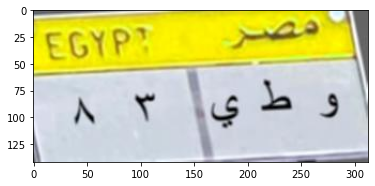

In [47]:
img=show_random_image(df)

Image Shape: (143, 319, 3)
Label: ه هم 9 9 9


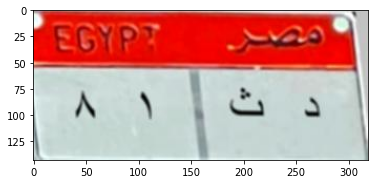

In [48]:
img=show_random_image(df)

Image Shape: (147, 305, 3)
Label: ه و م 4 4


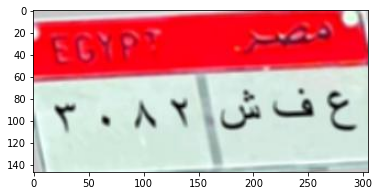

In [49]:
img=show_random_image(df)

In [50]:

df = pd.read_csv("results_spaces.csv")
for idx, label in enumerate(df['label']):
    df['label'][idx] = label.replace(" ","")
df.to_csv("results_without_spaces.csv", index=False)

In [51]:
from keras.models import model_from_json# serialize model to json 
json_model = act_model.to_json()#save the model architecture to JSON file 
with open('final_model.json', 'w') as json_file: 
    json_file.write(json_model)#saving the weights of the model 
act_model.save_weights('final_model.h5')#Model loss and accuracy 

In [52]:
from keras.initializers import glorot_uniform 
#Reading the model from JSON file 
with open('final_model.json', 'r') as json_file: 
    json_savedModel= json_file.read()#load the model architecture  
model_j = tf.keras.models.model_from_json(json_savedModel) 
model_j.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 128)      512   

In [53]:
model_j.load_weights('final_model.h5')


In [54]:
model_j.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')


In [55]:
 
# predict outputs on validation images
prediction = model_j.predict(valid_img[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x: 
       
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

original_text =   ظ ح 4 7 9 1
predicted text = ظ ح 4 7 9 1

original_text =   ت ج ث 7
predicted text = ت ج ث 7

original_text =   ق ل 3
predicted text = ق ل 3

original_text =   ن ذ 4 7 2
predicted text = ن ذ 4 7 2

original_text =   غ ل ع 8
predicted text = غ ل ع 8

original_text =   م ط ز 6 8
predicted text = م ط ز 6 8

original_text =   ى س د 3 2
predicted text = ى س د 3 2

original_text =   ظ ظ 6
predicted text = ظ ظ 6

original_text =   ص ل غ 7
predicted text = ص ل غ 7

original_text =   و ح 7 2 5
predicted text = و ح 7 2 5

